In [ ]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from scikeras.wrappers import KerasRegressor
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



In [ ]:
dataset = pd.read_csv('/content/final_data_LSTM.csv')
print(dataset.head())
dataset.set_index('datetime', inplace=True)

              datetime     Close  sentiment_polarization  Close_1hr  \
0  2021-01-01 02:00:00  0.224018                0.561453   0.534654   
1  2021-01-01 03:00:00  0.225666                0.585239   0.561453   
2  2021-01-01 04:00:00  0.224523                0.670205   0.585239   
3  2021-01-01 05:00:00  0.223868                0.732950   0.670205   
4  2021-01-01 06:00:00  0.223619                0.562987   0.732950   

   sentiment_lag_1hr  Close_2hr  sentiment_lag_2hr  Close_lag_back_1hr  \
0           0.534654   0.693206           0.693206            0.585239   
1           0.561453   0.534654           0.534654            0.670205   
2           0.585239   0.561453           0.561453            0.732950   
3           0.670205   0.585239           0.585239            0.562987   
4           0.732950   0.670205           0.670205            0.697251   

   sentiment_lag_back_1hr  sentiment_lag_back_2hr  ...  Volume USDT_back_1hr  \
0                0.585239                0.67020

In [ ]:
dataset.shape

(12307, 25)

## Preparing the data as training data and test data for LSTM model training

In [ ]:
test_split=round(len(dataset)*0.30)
test_split

3692

In [ ]:

df_for_training=dataset[:-3692]
df_for_testing=dataset[-3692:]
print(df_for_training.shape)
print(df_for_testing.shape)

(8615, 25)
(3692, 25)


In [ ]:
# @title
def createXY(dataset, n_past, target_col_index=0):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        # Append the past n_past rows of all columns except the target column
        dataX.append(np.delete(dataset[i - n_past:i, :], target_col_index, axis=1))
        # Append the current value of the target column
        dataY.append(dataset[i, target_col_index])
    return np.array(dataX), np.array(dataY)

# Assuming your DataFrame is df_for_training and df_for_testing
# and your target variable is in the first column (index 0)
trainX, trainY = createXY(df_for_training.values, 30)
testX, testY = createXY(df_for_testing.values, 30)

In [ ]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training.values,30)
testX,testY=createXY(df_for_testing.values,30)

In [ ]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (8585, 30, 25)
trainY Shape--  (8585,)


In [ ]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (3662, 30, 25)
testY Shape--  (3662,)


## LSTM

In [12]:
def build_model(optimizer='adam'):
    grid_model = Sequential()
    grid_model.add(LSTM(50, return_sequences=True, input_shape=(30, 25)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss='mse', optimizer=optimizer)
    return grid_model

# Define the KerasRegressor
grid_model = KerasRegressor(model=build_model, verbose=1)

# Define the grid search parameters
parameters = {
    'batch_size': [32, 64, 128, 256, 512, 1024],
    'epochs': [8, 10, 12, 14, 16, 18, 20],
    'optimizer': ['adam', 'Adadelta']
}

# Perform the grid search
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(trainX, trainY, validation_data=(testX, testY))
best_model = grid_search.best_estimator_.model_

# Print the best parameters and the best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0313 - val_loss: 6.8435e-04
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0029 - val_loss: 4.1300e-04
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0027 - val_loss: 8.7261e-04
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0024 - val_loss: 1.8030e-04
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0019 - val_loss: 1.1934e-04
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - val_loss: 1.2646e-04
Epoch 8/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0016 - val_loss: 2.1999e-04
Epoch 9/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0014 - val_loss: 1.1733e-04
Epoch 10/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0012 - val_loss: 1.8940e-04
Epoch 11/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - val_loss: 1.3022e-04
Epoch 12/

In [13]:
# Make predictions
predictions = best_model.predict(testX)

# Calculate metrics
r2 = r2_score(testY, predictions)
mae = mean_absolute_error(testY, predictions)
mse = mean_squared_error(testY, predictions)
rmse = np.sqrt(mse)

# Print the metrics
print(f'R-squared (R2): {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
R-squared (R2): 0.9922463550509814
Mean Absolute Error (MAE): 0.006202427207888979
Mean Squared Error (MSE): 7.415630223935945e-05
Root Mean Squared Error (RMSE): 0.008611405357974937


In [14]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          15,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106,355 (415.45 KB)

 Trainable params: 35,451 (138.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 70,904 (276.97 KB)

In [15]:
# Save the best model
best_model.save('best_lstm_model.h5')

Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0257 - val_loss: 5.6703e-04
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0029 - val_loss: 3.9923e-04
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0024 - val_loss: 1.9447e-04
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0023 - val_loss: 1.3429e-04
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0018 - val_loss: 2.6833e-04
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017 - val_loss: 2.7966e-04
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - val_loss: 5.0575e-04
Epoch 8/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0015 - val_loss: 1.6610e-04
Epoch 9/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - val_loss: 4.0464e-04
Epoch 10/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - val_loss: 1.2302e-04
Epoch 11/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - val_loss: 1.4291e-04
Epoch 

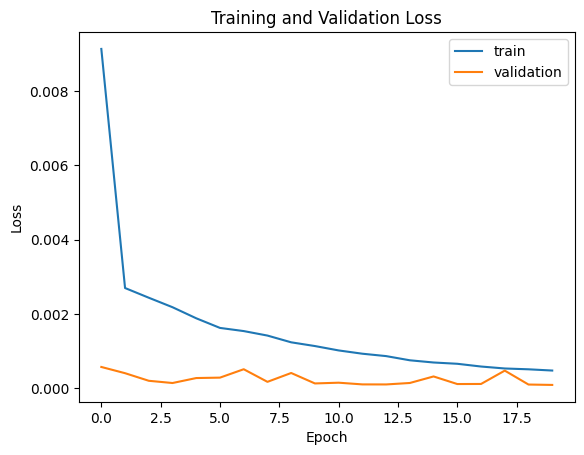

In [20]:
# Fit the best model with the best parameters to get the history
best_params = grid_search.best_params_
best_model = build_model(optimizer=best_params['optimizer'])

history = best_model.fit(trainX, trainY,
                         batch_size=best_params['batch_size'],
                         epochs=best_params['epochs'],
                         validation_data=(testX, testY),
                         verbose=1)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

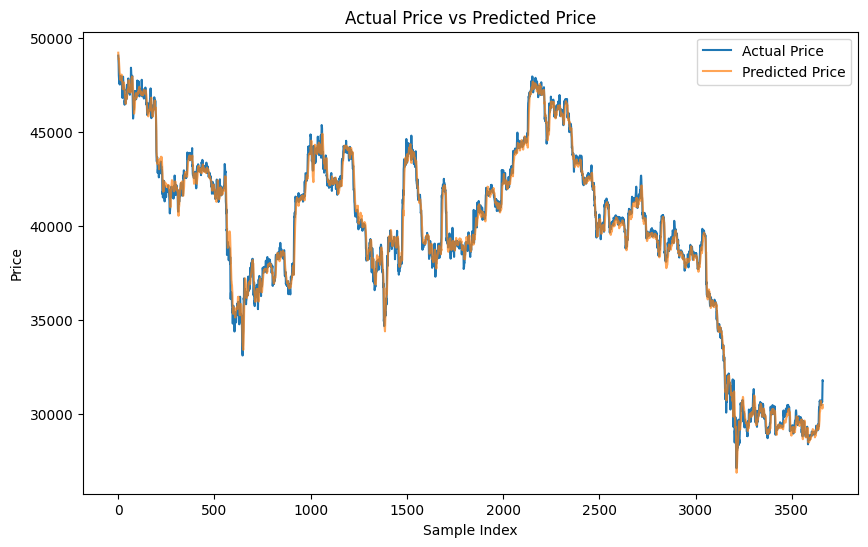

In [28]:
min_price = 17809
max_price = 68633.69

# Reverse the normalization
original_predictions = predictions * (max_price - min_price) + min_price
original_actual = testY * (max_price - min_price) + min_price

# Flatten the predictions and actual values if necessary (depending on your data shape)
predictions = original_predictions.flatten()
actual = original_actual.flatten()

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price', alpha=0.7)
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()